In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind

In [127]:
pd.set_option('display.max_rows', 50) # показывать больше строк
pd.set_option('display.max_columns', 50) # показывать больше колонок

students = pd.read_csv('stud_math.csv')

In [3]:
students

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,MS,M,20,U,LE3,A,2.0,2.0,services,services,course,NaN,1.0,2.0,2.0,no,yes,yes,no,yes,-6.0,yes,no,no,5.0,5.0,4.0,4.0,212.0,45.0
391,MS,M,17,U,LE3,T,3.0,1.0,services,services,course,mother,2.0,1.0,0.0,no,no,no,no,no,-3.0,yes,yes,no,2.0,4.0,5.0,2.0,3.0,80.0
392,MS,M,21,R,GT3,T,1.0,1.0,other,other,course,NaN,1.0,1.0,3.0,NaN,no,no,no,no,-3.0,NaN,no,no,5.0,5.0,3.0,3.0,3.0,35.0
393,MS,M,18,R,LE3,T,3.0,2.0,services,other,course,mother,3.0,1.0,0.0,no,no,no,NaN,no,-3.0,yes,yes,no,4.0,4.0,1.0,5.0,0.0,50.0


## Предобработка

In [4]:
# Функция для вывода информации для номинативных переменных
def column_info(data: pd.DataFrame, column: str) -> None:
    n = 10 # Параметр для оценки наиболее часто встречающихся значений
    print(f'Проведем анализ для переменной {column}')
    
    print('Всего значений:', data.shape[0])
    print('Пустых значений:', data.shape[0] - data[column].notnull().sum())
    print(f'Значений, упомянутых более {n} раз:', (data[column].value_counts() > n).sum())
    print('Уникальных значений:', data[column].nunique())
    
    display(pd.DataFrame(data[column].value_counts()))
    
    data.loc[:,[column]].info()
    

# Функция для вывода информации для колличественных переменных
def plot_column_info(data: pd.DataFrame, column: str) -> None:  
    max_value = data[column].max()
    min_value = data[column].min()
    perc25 = data[column].quantile(0.25)
    perc75 = data[column].quantile(0.75)
    IQR = perc75 - perc25
    lower_limt = perc25 - 1.5*IQR
    upper_limit = perc75 + 1.5*IQR
    
    if max_value <= upper_limit and min_value >= lower_limt:
        outliers_status = 'Выбросов Нет.'
    else:
        outliers_status = 'Есть выбросы.'

    print('25-й перцентиль: {},'.format(perc25))
    print('75-й перцентиль: {},'.format(perc75))
    print('IQR: {}, '.format(IQR))
    print(f'Границы значений: [{min_value}, {max_value}.')
    print('Границы выбросов: [{f}, {l}],'.format(f=lower_limt, l=upper_limit))
    print(outliers_status)
    
    data[column].loc[data[column].between(lower_limt, upper_limit)].hist(bins=16,
                                                                         range=(min_value, max_value), 
                                                                         label='IQR')

    data[column].hist(alpha=0.5, 
                      bins=16, 
                      range=(min_value, max_value), 
                      label='Исходные значения')

    plt.legend();
    

# Функция для удаления выбросов с помощью IQR. Пустые значения оставляет.
def remove_outliers_iqr(data: pd.DataFrame, column: str) -> pd.DataFrame: 
    perc25 = data[column].quantile(0.25)
    perc75 = data[column].quantile(0.75)
    IQR = perc75 - perc25
    lower_limt = perc25 - 1.5*IQR
    upper_limit = perc75 + 1.5*IQR  
    
    return data.query(f'{lower_limt} <= {column} <= {upper_limit} or {column} != {column}')


# Функция для удаления выбросов исходя из здравого смысла. Пустые значения оставляет.
def remove_outliers_real(data: pd.DataFrame, column: str, lower_limt: float, upper_limit: float) -> pd.DataFrame: 
    
    return data.query(f'{lower_limt} <= {column} <= {upper_limit} or {column} != {column}')

In [128]:
columns_object = list(students.select_dtypes(include=['object']).columns)
columns_int =  list(students.select_dtypes(include=['int', 'float']).columns)

В предобработку выносим удаление "лишних" столбцов и устранение выбросов. Но так как это проверочная работа, то в ней будут смотреть не только конечный результат, но и само решение и причины, почему был удален тот или иной выброс. Поэтому код в следующем блоке закомментируем, а преобразование датасета сделаем в ходе решения.

In [6]:
''' 
# Для признака 'Fedu' убираем "лишние" значения
students = students.query('Fedu in [None, 0, 1, 2, 3, 4]')

# Убираем признак 'studytime, granular', так как он линейно зависим от 'studytime'
students.drop(['studytime, granular'], inplace = True, axis = 1)

# Для признака 'famrel' убираем "лишние" значения
students = students.query('famrel in [None, 1, 2, 3, 4, 5]')

# Для признака 'absences' уберем выбросы определенные с помощью IQR
students = remove_outliers_iqr(students, 'absences')

# Для признака 'Pstatus' пустые значения заполним самым распространенным значением - 'T'
students.loc[students['Pstatus'] != students['Pstatus'], 'Pstatus'] = 'T'
'''

Посмотрим на количество пустых значений наших признаков:

In [148]:
students.isna().sum()

school                  0
sex                     0
age                     0
address                 0
famsize                27
Pstatus                45
Medu                    3
Fedu                   24
Mjob                   19
Fjob                   36
reason                 17
guardian               31
traveltime             28
studytime               7
failures               22
schoolsup               9
famsup                 39
paid                   40
activities             14
nursery                16
studytime, granular     7
higher                 20
internet               34
romantic               31
famrel                 27
freetime               11
goout                   8
health                 15
absences               12
score                   6
dtype: int64

Это довольно много для нашего небольшого набора данных (395 строк). Просто удалить их плохо. Попробуем заполнить их исходя из логических рассуждений.

В предобработку выносим замену пустых значений. Но так как это проверочная работа, то в ней будут смотреть не только конечный результат, но и само решение и рассуждения, на какое значение был заменен NaN. Поэтому код в следующем блоке закомментируем, а преобразование датасета сделаем в ходе решения.

In [ ]:
'''
# Для признака 'address' заполним пустые значения исходя из значений признака 'traveltime'
students.loc[(students['address'] != students['address']) 
             & students['traveltime'].isin([3.0, 4.0]), 'address'] = 'R'
students.loc[(students['address'] != students['address']) 
             & students['traveltime'].isin([None, 1.0, 2.0]), 'address'] = 'U'

# Для признака 'famsize' заполним пустые значения 'LE3'
students.loc[students['famsize'] != students['famsize'], 'famsize'] = 'LE3'


'''



## Номинативные переменные
### School
school — аббревиатура школы, в которой учится ученик

In [129]:
column = 'school'
column_info(students, column)

Проведем анализ для переменной school
Всего значений: 395
Пустых значений: 0
Значений, упомянутых более 10 раз: 2
Уникальных значений: 2


,school
GP,349
MS,46


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
school    395 non-null object
dtypes: object(1)
memory usage: 3.2+ KB


Пустых значений нет. Значений, требующих дополнительной обработки, тоже нет.

С данной переменной все хорошо. Оставляем как есть.

### Sex
sex — пол ученика ('F' - женский, 'M' - мужской)

In [130]:
column = 'sex'
column_info(students, column)

Проведем анализ для переменной sex
Всего значений: 395
Пустых значений: 0
Значений, упомянутых более 10 раз: 2
Уникальных значений: 2


,sex
F,208
M,187


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
sex    395 non-null object
dtypes: object(1)
memory usage: 3.2+ KB


Пустых значений нет. Значений, требующих дополнительной обработки, тоже нет.

С данной переменной все хорошо. Оставляем как есть.

### Adress
address — тип адреса ученика ('U' - городской, 'R' - за городом)

In [131]:
column = 'address'
column_info(students, column)

Проведем анализ для переменной address
Всего значений: 395
Пустых значений: 17
Значений, упомянутых более 10 раз: 2
Уникальных значений: 2


,address
U,295
R,83


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
address    378 non-null object
dtypes: object(1)
memory usage: 3.2+ KB


Есть 17 пустых значений. Это довольно много для нашего небольшого набора данных. Просто удалить их плохо. Попробуем заполнить их исходя из логических рассуждений.

In [132]:
students.query(f'{column} != {column}')

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
6,GP,M,16,NaN,LE3,T,2.0,2.0,other,other,home,mother,1.0,2.0,0.0,no,no,no,no,yes,-6.0,yes,yes,no,4.0,4.0,4.0,3.0,0.0,55.0
52,GP,M,15,NaN,LE3,A,4.0,2.0,health,NaN,other,father,2.0,1.0,1.0,no,NaN,no,no,yes,-3.0,yes,NaN,no,5.0,5.0,5.0,5.0,6.0,50.0
75,GP,M,15,NaN,GT3,T,4.0,3.0,teacher,other,home,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,NaN,NaN,3.0,3.0,5.0,6.0,50.0
92,GP,F,16,NaN,LE3,T,NaN,1.0,other,other,home,father,1.0,2.0,0.0,yes,yes,no,no,yes,-6.0,yes,no,no,3.0,3.0,NaN,2.0,4.0,30.0
96,GP,M,16,NaN,GT3,NaN,4.0,3.0,services,other,reputation,mother,2.0,1.0,0.0,yes,yes,NaN,yes,no,-3.0,NaN,yes,no,3.0,3.0,3.0,4.0,2.0,75.0
159,GP,M,16,NaN,GT3,T,3.0,NaN,other,services,course,father,1.0,2.0,1.0,no,yes,yes,no,yes,-6.0,yes,yes,yes,4.0,5.0,5.0,5.0,4.0,60.0
168,GP,F,16,NaN,GT3,T,2.0,2.0,other,other,home,mother,1.0,2.0,0.0,no,yes,yes,no,no,-6.0,yes,yes,no,5.0,1.0,5.0,4.0,0.0,0.0
241,GP,M,17,NaN,LE3,A,4.0,4.0,teacher,other,course,mother,NaN,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,yes,no,3.0,3.0,NaN,4.0,2.0,60.0
254,GP,M,17,NaN,NaN,T,2.0,1.0,other,other,course,mother,1.0,1.0,0.0,no,no,no,no,no,-3.0,yes,yes,no,4.0,4.0,2.0,5.0,NaN,60.0
270,GP,F,19,NaN,GT3,T,3.0,3.0,other,services,home,other,1.0,2.0,2.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,4.0,3.0,5.0,5.0,NaN,NaN


Исходя из описания, можно предположить, что наш признак address связан с traveltime - время пути от дома до школы. Посторим сводную таблицу для этих признаков.

In [133]:
pivot = students.pivot_table(
    values=['school'],
    index=['address'],
    columns=['traveltime'],
    aggfunc='count',
    fill_value=0
)
display(pivot)

school            
traveltime    1.0 2.0 3.0 4.0
address                      
R              34  26  12   4
U             200  65   9   3

Для значений traveltime = 1 или 2, значение address чаще встречается = U. А для значений traveltime = 3 или 4 чаще встречается R.
Заполним пустые значения нашего признака address исходя из этой закономерности. 

In [134]:
# Вынесем данный блок в предобработку
students.loc[(students['address'] != students['address']) 
             & students['traveltime'].isin([3.0, 4.0]), 'address'] = 'R'
students.loc[(students['address'] != students['address']) 
             & students['traveltime'].isin([None, 1.0, 2.0]), 'address'] = 'U'

In [135]:
column_info(students, column)

Проведем анализ для переменной address
Всего значений: 395
Пустых значений: 0
Значений, упомянутых более 10 раз: 2
Уникальных значений: 2


,address
U,311
R,84


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
address    395 non-null object
dtypes: object(1)
memory usage: 3.2+ KB


Значений, требующих дополнительной обработки, нет. Пустых значений нет.

С данной переменной все хорошо. Оставляем как есть.

### Famsize
famsize — размер семьи('LE3' <= 3, 'GT3' >3)

In [150]:
column = 'famsize'
column_info(students, column)

Проведем анализ для переменной famsize
Всего значений: 395
Пустых значений: 27
Значений, упомянутых более 10 раз: 2
Уникальных значений: 2


,famsize
GT3,261
LE3,107


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
famsize    368 non-null object
dtypes: object(1)
memory usage: 3.2+ KB


Посмотрим на такую выборку:

In [154]:
df = students.query(f'{column} != {column} and (Medu == Medu or Fedu == Fedu or Mjob == Mjob or Fjob == Fjob)')
display(df.shape)
display(df)

(27, 30)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
9,GP,M,15,U,NaN,NaN,3.0,4.0,other,other,home,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,5.0,5.0,1.0,5.0,0.0,75.0
32,GP,M,15,R,NaN,T,4.0,3.0,teacher,at_home,course,mother,1.0,2.0,0.0,no,yes,no,yes,NaN,-6.0,yes,yes,yes,4.0,NaN,2.0,5.0,0.0,80.0
36,GP,M,15,U,NaN,T,4.0,3.0,teacher,services,home,mother,1.0,3.0,0.0,no,yes,no,yes,yes,-9.0,yes,yes,no,5.0,4.0,3.0,4.0,2.0,90.0
76,GP,M,15,U,NaN,T,4.0,0.0,teacher,other,course,mother,2.0,4.0,0.0,no,no,no,yes,yes,-12.0,NaN,yes,no,3.0,4.0,3.0,1.0,8.0,50.0
78,GP,M,17,U,NaN,T,2.0,1.0,other,other,home,mother,2.0,1.0,3.0,yes,NaN,no,yes,yes,-3.0,no,yes,no,4.0,5.0,1.0,3.0,2.0,50.0
79,GP,F,16,U,NaN,T,3.0,4.0,at_home,other,course,mother,1.0,2.0,0.0,NaN,yes,no,no,yes,-6.0,yes,yes,no,2.0,4.0,3.0,3.0,12.0,25.0
114,GP,M,15,R,NaN,T,2.0,1.0,health,services,reputation,mother,1.0,2.0,NaN,no,no,no,yes,yes,-6.0,yes,yes,yes,5.0,4.0,2.0,5.0,8.0,45.0
128,GP,M,18,R,NaN,T,2.0,2.0,NaN,other,reputation,mother,1.0,1.0,2.0,no,yes,no,yes,yes,-3.0,yes,yes,no,3.0,3.0,3.0,4.0,0.0,0.0
129,GP,M,16,R,NaN,T,4.0,4.0,teacher,teacher,course,mother,1.0,NaN,0.0,no,no,yes,yes,yes,NaN,yes,yes,no,3.0,5.0,5.0,4.0,NaN,90.0


Видим, что для всех 27 студентов, у которых указаны пустые значения для признака famsize, верно утверждение, что у них есть как мама, так и папа, т.е. в семье их как минимаум трое. Можно указать вместо пустого значения 'LE3' <= 3. Можно даже без поиска мамы и папы, под условие подходит.

Причин указать 'GT3' > 3, что несет за собой дополнительную информацию, не вижу. Только если признак guardian == other, но с ним мало что понятно.

In [155]:
# Вынесем данный блок в предобработку
students.loc[students['famsize'] != students['famsize'], 'famsize'] = 'LE3'

In [156]:
column_info(students, column)

Проведем анализ для переменной famsize
Всего значений: 395
Пустых значений: 0
Значений, упомянутых более 10 раз: 2
Уникальных значений: 2


,famsize
GT3,261
LE3,134


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
famsize    395 non-null object
dtypes: object(1)
memory usage: 3.2+ KB


Значений, требующих дополнительной обработки, нет. Пустых значений нет.

С данной переменной все хорошо. Оставляем как есть.

### Pstatus
Pstatus — статус совместного жилья родителей ('T' - живут вместе 'A' - раздельно)

In [157]:
column = 'Pstatus'
column_info(students, column)

Проведем анализ для переменной Pstatus
Всего значений: 395
Пустых значений: 45
Значений, упомянутых более 10 раз: 2
Уникальных значений: 2


,Pstatus
T,314
A,36


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
Pstatus    350 non-null object
dtypes: object(1)
memory usage: 3.2+ KB


Исходя из описания, можно предположить, что наш признак Pstatus связан с famrel - семейные отношения. Посторим сводную таблицу для этих признаков.

In [160]:
pivot = students.pivot_table(
    values=['school'],
    index=['Pstatus'],
    columns=['famrel'],
    aggfunc='count',
    fill_value=0
)
display(pivot)

school                 
famrel     1.0 2.0 3.0  4.0 5.0
Pstatus                        
A            1   3   5   12  11
T            4  14  48  150  75

Из сводной таблицы этого не видно. Видимо, не все так просто. 
Поэтому заполним пустые значения самым распространенным значением - 'T'.

In [161]:
# Вынесем данный блок в предобработку
students.loc[students['Pstatus'] != students['Pstatus'], 'Pstatus'] = 'T'

In [162]:
column_info(students, column)

Проведем анализ для переменной Pstatus
Всего значений: 395
Пустых значений: 0
Значений, упомянутых более 10 раз: 2
Уникальных значений: 2


,Pstatus
T,359
A,36


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
Pstatus    395 non-null object
dtypes: object(1)
memory usage: 3.2+ KB


Значений, требующих дополнительной обработки, нет. Пустых значений нет.

С данной переменной все хорошо. Оставляем как есть.

### Mjob
Mjob — работа матери ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба, 'at_home' - не работает, 'other' - другое)

In [164]:
column = 'Mjob'
column_info(students, column)

Проведем анализ для переменной Mjob
Всего значений: 395
Пустых значений: 19
Значений, упомянутых более 10 раз: 5
Уникальных значений: 5


,Mjob
other,133
services,98
at_home,58
teacher,55
health,32


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
Mjob    376 non-null object
dtypes: object(1)
memory usage: 3.2+ KB


In [165]:
students.query(f'{column} != {column}')

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
29,GP,M,16,U,GT3,T,4.0,4.0,NaN,teacher,home,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,yes,4.0,4.0,5.0,5.0,16.0,55.0
54,GP,F,15,U,LE3,T,3.0,3.0,NaN,other,other,mother,1.0,1.0,NaN,no,no,yes,NaN,yes,-3.0,yes,yes,NaN,5.0,3.0,4.0,1.0,6.0,65.0
59,GP,F,16,U,GT3,T,4.0,2.0,NaN,NaN,course,mother,NaN,2.0,0.0,no,NaN,no,no,yes,-6.0,yes,yes,no,4.0,2.0,3.0,5.0,2.0,80.0
88,GP,M,16,U,GT3,T,2.0,2.0,NaN,other,reputation,father,2.0,2.0,1.0,no,no,yes,yes,NaN,-6.0,yes,yes,no,4.0,4.0,2.0,NaN,12.0,50.0
104,GP,M,15,U,GT3,A,3.0,4.0,NaN,other,course,mother,NaN,2.0,0.0,no,yes,NaN,yes,yes,-6.0,yes,yes,no,5.0,4.0,4.0,1.0,0.0,90.0
128,GP,M,18,R,LE3,T,2.0,2.0,NaN,other,reputation,mother,1.0,1.0,2.0,no,yes,no,yes,yes,-3.0,yes,yes,no,3.0,3.0,3.0,4.0,0.0,0.0
145,GP,F,15,U,GT3,T,1.0,1.0,NaN,services,course,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,yes,no,4.0,4.0,2.0,NaN,0.0,55.0
156,GP,M,17,R,LE3,T,1.0,2.0,NaN,other,reputation,mother,1.0,1.0,0.0,no,no,no,no,yes,-3.0,yes,no,no,2.0,2.0,2.0,5.0,8.0,65.0
166,GP,M,16,U,GT3,T,2.0,2.0,NaN,other,course,father,1.0,2.0,0.0,no,no,no,no,yes,-6.0,no,yes,no,4.0,3.0,5.0,4.0,4.0,50.0
174,GP,F,16,U,LE3,T,3.0,3.0,NaN,other,reputation,mother,2.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,4.0,4.0,5.0,4.0,4.0,45.0


Исходя из описания, можно предположить, что наш признак Mjob связан с Medu - образование матери. Посторим сводную таблицу для этих признаков.

In [167]:
pivot = students.pivot_table(
    values=['school'],
    index=['Mjob'],
    columns=['Medu'],
    aggfunc='count',
    fill_value=0
)
display(pivot)

school                
Medu        0.0 1.0 2.0 3.0 4.0
Mjob                           
at_home       2  25  21   8   2
health        0   1   2   5  24
other         1  26  45  37  22
services      0   5  30  38  24
teacher       0   0   0   3  52

Значений, требующих дополнительной обработки, нет. Есть 19 пустых значений.

С данной переменной все хорошо. Оставляем как есть.

### Fjob
Fjob— работа отца ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба, 'at_home' - не работает, 'other' - другое)

In [13]:
column = 'Fjob'
column_info(students, column)

Проведем анализ для переменной Fjob
Всего значений: 395
Пустых значений: 36
Значений, упомянутых более 10 раз: 5
Уникальных значений: 5


,Fjob
other,197
services,102
teacher,29
at_home,16
health,15


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
Fjob    359 non-null object
dtypes: object(1)
memory usage: 3.2+ KB


Значений, требующих дополнительной обработки, нет. Есть 36 пустых значений.

С данной переменной все хорошо. Оставляем как есть.

### Reason
reason — причина выбора школы ('home' - близость к дому, 'reputation' - репутация школы, 'course' - образовательная программа, 'other' - другое)

In [14]:
column = 'reason'
column_info(students, column)

Проведем анализ для переменной reason
Всего значений: 395
Пустых значений: 17
Значений, упомянутых более 10 раз: 4
Уникальных значений: 4


,reason
course,137
home,104
reputation,103
other,34


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
reason    378 non-null object
dtypes: object(1)
memory usage: 3.2+ KB


Значений, требующих дополнительной обработки, нет. Есть 17 пустых значений.

С данной переменной все хорошо. Оставляем как есть.

### Guardian
guardian — опекун ('mother' - мать, 'father' - отец, 'other' - другое)

In [15]:
column = 'guardian'
column_info(students, column)

Проведем анализ для переменной guardian
Всего значений: 395
Пустых значений: 31
Значений, упомянутых более 10 раз: 3
Уникальных значений: 3


,guardian
mother,250
father,86
other,28


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
guardian    364 non-null object
dtypes: object(1)
memory usage: 3.2+ KB


Значений, требующих дополнительной обработки, нет. Есть 31 пустых значений.

С данной переменной все хорошо. Оставляем как есть.

### Schoolsup
schoolsup — дополнительная образовательная поддержка (yes или no)

In [16]:
column = 'schoolsup'
column_info(students, column)

Проведем анализ для переменной schoolsup
Всего значений: 395
Пустых значений: 9
Значений, упомянутых более 10 раз: 2
Уникальных значений: 2


,schoolsup
no,335
yes,51


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
schoolsup    386 non-null object
dtypes: object(1)
memory usage: 3.2+ KB


Значений, требующих дополнительной обработки, нет. Есть 9 пустых значений.

С данной переменной все хорошо. Оставляем как есть.

### Famsup
famsup — семейная образовательная поддержка (yes или no)

In [17]:
column = 'famsup'
column_info(students, column)

Проведем анализ для переменной famsup
Всего значений: 395
Пустых значений: 39
Значений, упомянутых более 10 раз: 2
Уникальных значений: 2


,famsup
yes,219
no,137


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
famsup    356 non-null object
dtypes: object(1)
memory usage: 3.2+ KB


Значений, требующих дополнительной обработки, нет. Есть 39 пустых значений.

С данной переменной все хорошо. Оставляем как есть.

### Paid
paid — дополнительные платные занятия по математике (yes или no)

In [18]:
column = 'paid'
column_info(students, column)

Проведем анализ для переменной paid
Всего значений: 395
Пустых значений: 40
Значений, упомянутых более 10 раз: 2
Уникальных значений: 2


,paid
no,200
yes,155


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
paid    355 non-null object
dtypes: object(1)
memory usage: 3.2+ KB


Значений, требующих дополнительной обработки, нет. Есть 40 пустых значений.

С данной переменной все хорошо. Оставляем как есть.

### Activities
activities — дополнительные внеучебные занятия (yes или no)

In [19]:
column = 'activities'
column_info(students, column)

Проведем анализ для переменной activities
Всего значений: 395
Пустых значений: 14
Значений, упомянутых более 10 раз: 2
Уникальных значений: 2


,activities
yes,195
no,186


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
activities    381 non-null object
dtypes: object(1)
memory usage: 3.2+ KB


Значений, требующих дополнительной обработки, нет. Есть 14 пустых значений.

С данной переменной все хорошо. Оставляем как есть.

### Nursery
nursery — посещал детский сад (yes или no)

In [20]:
column = 'nursery'
column_info(students, column)

Проведем анализ для переменной nursery
Всего значений: 395
Пустых значений: 16
Значений, упомянутых более 10 раз: 2
Уникальных значений: 2


,nursery
yes,300
no,79


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
nursery    379 non-null object
dtypes: object(1)
memory usage: 3.2+ KB


Значений, требующих дополнительной обработки, нет. Есть 16 пустых значений.

С данной переменной все хорошо. Оставляем как есть.

### Higher
higher — хочет получить высшее образование (yes или no)

In [21]:
column = 'higher'
column_info(students, column)

Проведем анализ для переменной higher
Всего значений: 395
Пустых значений: 20
Значений, упомянутых более 10 раз: 2
Уникальных значений: 2


,higher
yes,356
no,19


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
higher    375 non-null object
dtypes: object(1)
memory usage: 3.2+ KB


Значений, требующих дополнительной обработки, нет. Есть 20 пустых значений.

С данной переменной все хорошо. Оставляем как есть.

### Internet
internet — наличие интернета дома (yes или no)

In [22]:
column = 'internet'
column_info(students, column)

Проведем анализ для переменной internet
Всего значений: 395
Пустых значений: 34
Значений, упомянутых более 10 раз: 2
Уникальных значений: 2


,internet
yes,305
no,56


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
internet    361 non-null object
dtypes: object(1)
memory usage: 3.2+ KB


Значений, требующих дополнительной обработки, нет. Есть 34 пустых значений.

С данной переменной все хорошо. Оставляем как есть.

### Romantic
romantic — в романтических отношениях (yes или no)

In [23]:
column = 'romantic'
column_info(students, column)

Проведем анализ для переменной romantic
Всего значений: 395
Пустых значений: 31
Значений, упомянутых более 10 раз: 2
Уникальных значений: 2


,romantic
no,240
yes,124


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
romantic    364 non-null object
dtypes: object(1)
memory usage: 3.2+ KB


Значений, требующих дополнительной обработки, нет. Есть 31 пустое значение.

С данной переменной все хорошо. Оставляем как есть.

## Колличественные признаки
## Age 
age — возраст ученика (от 15 до 22)

25-й перцентиль: 16.0,
75-й перцентиль: 18.0,
IQR: 2.0, 
Границы значений: [15, 22.
Границы выбросов: [13.0, 21.0],
Есть выбросы.


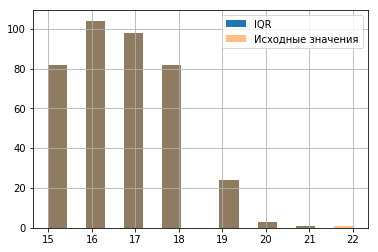

In [24]:
column = 'age'
plot_column_info(students, column)

Верхняя граница выбросов определена как 21, но в описании поля указано, что максимально возможное значение 22. Максимальное значение поля в нашем датасете не превышает 22, значит выбросов нет. 

С данным признаком все хорошо. Оставляем как есть.

### Medu
Medu — образование матери (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)

Признак может принимать только 5 выше указанных значения. Посмотрим, так ли это и не требуется ли дополнительная обработка.

In [25]:
column = 'Medu'
column_info(students, column)

Проведем анализ для переменной Medu
Всего значений: 395
Пустых значений: 3
Значений, упомянутых более 10 раз: 4
Уникальных значений: 5


,Medu
4.0,131
2.0,102
3.0,97
1.0,59
0.0,3


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
Medu    392 non-null float64
dtypes: float64(1)
memory usage: 3.2 KB


Значений, требующих дополнительной обработки, нет. Есть 3 пустых значения.

Посмотрим на гистограмму этого признака:

25-й перцентиль: 2.0,
75-й перцентиль: 4.0,
IQR: 2.0, 
Границы значений: [0.0, 4.0.
Границы выбросов: [-1.0, 7.0],
Выбросов Нет.


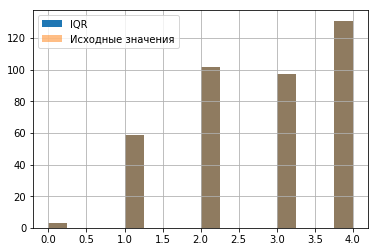

In [26]:
plot_column_info(students, column)

С данным признаком все хорошо. Оставляем как есть.

### Fedu
Fedu — образование отца (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)

Признак может принимать только 5 выше указанных значения. Посмотрим, так ли это и не требуется ли дополнительная обработка.

In [27]:
column = 'Fedu'
column_info(students, column)

Проведем анализ для переменной Fedu
Всего значений: 395
Пустых значений: 24
Значений, упомянутых более 10 раз: 4
Уникальных значений: 6


,Fedu
2.0,106
3.0,96
4.0,88
1.0,78
0.0,2
40.0,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
Fedu    371 non-null float64
dtypes: float64(1)
memory usage: 3.2 KB


Видим, что в одной из записей было указано 40, что явно является некорректно значением для данного признака. Также это значение, скорее всего, будет выбросом, посмотрим:

25-й перцентиль: 2.0,
75-й перцентиль: 3.0,
IQR: 1.0, 
Границы значений: [0.0, 40.0.
Границы выбросов: [0.5, 4.5],
Есть выбросы.


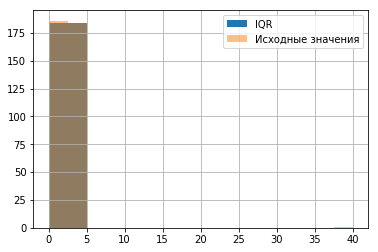

In [28]:
plot_column_info(students, column)

Да, так и есть. Но границы выбросов, рассчитанные с помощью IQR, 0.5 и 4.5. В таком случае 0 - также выброс, но является корректным значением согласно описанию. У нас в датасете есть две записи со значением 0 для рассматриваемого признака. Поэтому отфильтровывать "лишние" записи будем исходя из здравого смысла, т.е. только те записи, признак которых принимает одно из значений 0, 1, 2, 3 и 4. Также оставим записи с пустым значенем. 

In [29]:
# Вынесем данное действие в предобработку.
students = students.query('Fedu in [None, 0, 1, 2, 3, 4]')

Построим гистограмму признака после корректировки:

25-й перцентиль: 2.0,
75-й перцентиль: 3.0,
IQR: 1.0, 
Границы значений: [0.0, 4.0.
Границы выбросов: [0.5, 4.5],
Есть выбросы.


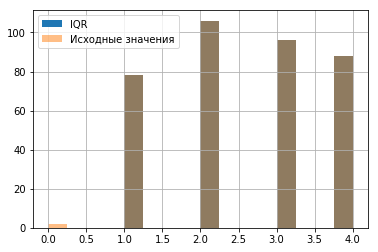

In [30]:
plot_column_info(students, column)

Теперь все хорошо.

### Traveltime
traveltime — время в пути до школы (1 - <15 мин., 2 - 15-30 мин., 3 - 30-60 мин., 4 - >60 мин.)

Признак может принимать только 4 выше указанных значения. Посмотрим, так ли это и не требуется ли дополнительная обработка.

In [31]:
column = 'traveltime'
column_info(students, column)

Проведем анализ для переменной traveltime
Всего значений: 394
Пустых значений: 28
Значений, упомянутых более 10 раз: 3
Уникальных значений: 4


,traveltime
1.0,242
2.0,96
3.0,21
4.0,7


<class 'pandas.core.frame.DataFrame'>
Int64Index: 394 entries, 0 to 394
Data columns (total 1 columns):
traveltime    366 non-null float64
dtypes: float64(1)
memory usage: 6.2 KB


Значений, требующих дополнительной обработки, нет. Есть 29 пустых значения.

Посмотрим на гистограмму этого признака:

25-й перцентиль: 1.0,
75-й перцентиль: 2.0,
IQR: 1.0, 
Границы значений: [1.0, 4.0.
Границы выбросов: [-0.5, 3.5],
Есть выбросы.


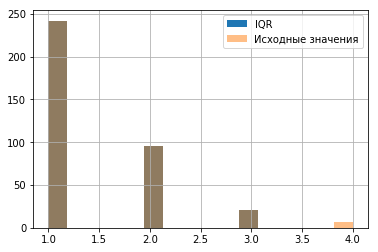

In [32]:
plot_column_info(students, column)

Границы выбросов, рассчитанные с помощью IQR, - [-0.5, 3.5]. В нашем датасете есть записи со значением признака 4, что согласно описанию признака является корректным.

С данным признаком все хорошо. Оставляем как есть.

### Studytime
studytime — время на учёбу помимо школы в неделю (1 - <2 часов, 2 - 2-5 часов, 3 - 5-10 часов, 4 - >10 часов)

Признак может принимать только 4 выше указанных значения. Посмотрим, так ли это и не требуется ли дополнительная обработка.

In [33]:
column = 'studytime'
column_info(students, column)

Проведем анализ для переменной studytime
Всего значений: 394
Пустых значений: 7
Значений, упомянутых более 10 раз: 4
Уникальных значений: 4


,studytime
2.0,194
1.0,103
3.0,63
4.0,27


<class 'pandas.core.frame.DataFrame'>
Int64Index: 394 entries, 0 to 394
Data columns (total 1 columns):
studytime    387 non-null float64
dtypes: float64(1)
memory usage: 6.2 KB


Значений, требующих дополнительной обработки, нет. Есть 7 пустых значений.

Посмотрим на гистограмму этого признака:

25-й перцентиль: 1.0,
75-й перцентиль: 2.0,
IQR: 1.0, 
Границы значений: [1.0, 4.0.
Границы выбросов: [-0.5, 3.5],
Есть выбросы.


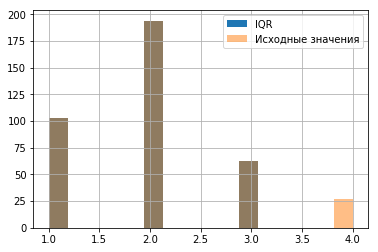

In [34]:
plot_column_info(students, column)

Границы выбросов, рассчитанные с помощью IQR, - [-0.5, 3.5]. В нашем датасете есть записи со значением признака 4, что согласно описанию признака является корректным.

С данным признаком все хорошо. Оставляем как есть.

### Failures
failures — количество внеучебных неудач (n, если 1<=n<=3, иначе 0)

Признак может принимать только 4 выше указанных значения. Посмотрим, так ли это и не требуется ли дополнительная обработка.

In [35]:
column = 'failures'
column_info(students, column)

Проведем анализ для переменной failures
Всего значений: 394
Пустых значений: 22
Значений, упомянутых более 10 раз: 4
Уникальных значений: 4


,failures
0.0,292
1.0,49
2.0,16
3.0,15


<class 'pandas.core.frame.DataFrame'>
Int64Index: 394 entries, 0 to 394
Data columns (total 1 columns):
failures    372 non-null float64
dtypes: float64(1)
memory usage: 6.2 KB


Значений, требующих дополнительной обработки, нет. Есть 22 пустых значений.

Посмотрим на гистограмму этого признака:

25-й перцентиль: 0.0,
75-й перцентиль: 0.0,
IQR: 0.0, 
Границы значений: [0.0, 3.0.
Границы выбросов: [0.0, 0.0],
Есть выбросы.


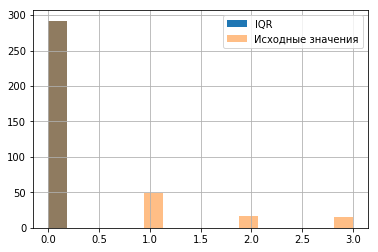

In [36]:
plot_column_info(students, column)

Границы выбросов, рассчитанные с помощью IQR, исключают любое значение кроме ноля. В нашем датасете есть записи со значением признака 1, 2 и 3, что согласно описанию признака является корректным.

С данным признаком все хорошо. Оставляем как есть.

### Studytime, granular
Описания данного признака нет. Есть признак со схожим названием - **studytime**. Сравним эти два признака:

In [37]:
students.loc[:, ['studytime', 'studytime, granular']].corr()

,studytime,"studytime, granular"
studytime,1.0,-1.0
"studytime, granular",-1.0,1.0


Эти два признака сильно скоррелированы. Можно предположить, что они линейно зависимы. Попробуем доказать.

Выразим первый элемент из первого признака через первый элемент второго признака.

In [38]:
x = students.loc[1, 'studytime']
y = students.loc[1, 'studytime, granular']
a = - y / x
print(f'{a}*x + y = {a*x + y}')

3.0*x + y = 0.0


Проверим, выражаются ли все остальные значения первого признака через элементы аторго с помощью найденного элемента:

In [39]:
x = students.loc[:, 'studytime']
y = students.loc[:, 'studytime, granular']
(a*x + y).abs().sum()

0.0

Да, так и есть. Таким образом мы получили, что второй признак есть то же самое, что и первый, только выраженный в других величинах. Дополнительной информации для анализа он не несет. Уберем его.

In [40]:
# Вынесем данное действие в предобработку.
students.drop(['studytime, granular'], inplace = True, axis = 1)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


### Famrel
famrel — семейные отношения (от 1 - очень плохо до 5 - очень хорошо)

Признак может принимать только 5 выше указанных значения. Посмотрим, так ли это и не требуется ли дополнительная обработка.

In [41]:
column = 'famrel'
column_info(students, column)

Проведем анализ для переменной famrel
Всего значений: 394
Пустых значений: 27
Значений, упомянутых более 10 раз: 4
Уникальных значений: 6


,famrel
4.0,182
5.0,98
3.0,62
2.0,17
1.0,7
-1.0,1


<class 'pandas.core.frame.DataFrame'>
Int64Index: 394 entries, 0 to 394
Data columns (total 1 columns):
famrel    367 non-null float64
dtypes: float64(1)
memory usage: 16.2 KB


Видим, что в одной из записей было указано -1, что явно является некорректным значением для данного признака. Также это значение, скорее всего, будет выбросом, посмотрим:

25-й перцентиль: 4.0,
75-й перцентиль: 5.0,
IQR: 1.0, 
Границы значений: [-1.0, 5.0.
Границы выбросов: [2.5, 6.5],
Есть выбросы.


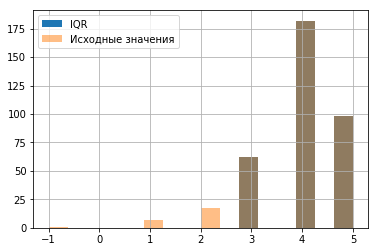

In [42]:
plot_column_info(students, column)

Да, так и есть. Но границы выбросов, рассчитанные с помощью IQR, [2.5 и 6.5]. В таком случае 1 и 2 - также выбросы, но являются корректным значением согласно описанию. У нас в датасете есть записи со значением 1 и 2 для рассматриваемого признака. Поэтому отфильтровывать "лишние" записи будем исходя из здравого смысла, т.е. только те записи, признак которых принимает одно из значений 1, 2, 3, 4 и 5. Также оставим записи с пустым значенем.

In [43]:
# Вынесем данное действие в предобработку.
students = students.query('famrel in [None, 1, 2, 3, 4, 5]')

Построим гистограммцу признака после корректировки:

25-й перцентиль: 4.0,
75-й перцентиль: 5.0,
IQR: 1.0, 
Границы значений: [1.0, 5.0.
Границы выбросов: [2.5, 6.5],
Есть выбросы.


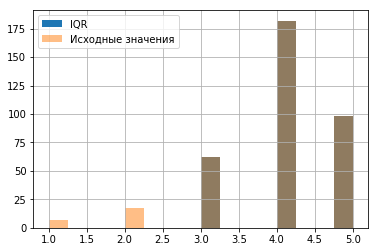

In [44]:
plot_column_info(students, column)

Значения признака в нужном диапазоне - указанном в описании. Теперь все хорошо.

### Freetime
freetime — свободное время после школы (от 1 - очень мало до 5 - очень мого)

Признак может принимать только 5 выше указанных значения. Посмотрим, так ли это и не требуется ли дополнительная обработка.

In [45]:
column = 'freetime'
column_info(students, column)

Проведем анализ для переменной freetime
Всего значений: 393
Пустых значений: 11
Значений, упомянутых более 10 раз: 5
Уникальных значений: 5


,freetime
3.0,153
4.0,112
2.0,61
5.0,38
1.0,18


<class 'pandas.core.frame.DataFrame'>
Int64Index: 393 entries, 0 to 394
Data columns (total 1 columns):
freetime    382 non-null float64
dtypes: float64(1)
memory usage: 6.1 KB


Значений, требующих дополнительной обработки, нет. Есть 11 пустых значений.

Посмотрим на гистограмму этого признака:

25-й перцентиль: 3.0,
75-й перцентиль: 4.0,
IQR: 1.0, 
Границы значений: [1.0, 5.0.
Границы выбросов: [1.5, 5.5],
Есть выбросы.


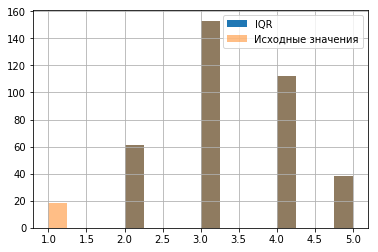

In [46]:
plot_column_info(students, column)

Границы выбросов, рассчитанные с помощью IQR, - [1.5, 5.5]. В нашем датасете есть записи со значением признака 1, что согласно описанию признака является корректным.

С данным признаком все хорошо. Оставляем как есть.

### Goout
goout — проведение времени с друзьями (от 1 - очень мало до 5 - очень много)

Признак может принимать только 5 выше указанных значения. Посмотрим, так ли это и не требуется ли дополнительная обработка.

In [47]:
column = 'goout'
column_info(students, column)

Проведем анализ для переменной goout
Всего значений: 393
Пустых значений: 8
Значений, упомянутых более 10 раз: 5
Уникальных значений: 5


,goout
3.0,127
2.0,99
4.0,84
5.0,52
1.0,23


<class 'pandas.core.frame.DataFrame'>
Int64Index: 393 entries, 0 to 394
Data columns (total 1 columns):
goout    385 non-null float64
dtypes: float64(1)
memory usage: 6.1 KB


Значений, требующих дополнительной обработки, нет. Есть 8 пустых значений.

Посмотрим на гистограмму этого признака:

25-й перцентиль: 2.0,
75-й перцентиль: 4.0,
IQR: 2.0, 
Границы значений: [1.0, 5.0.
Границы выбросов: [-1.0, 7.0],
Выбросов Нет.


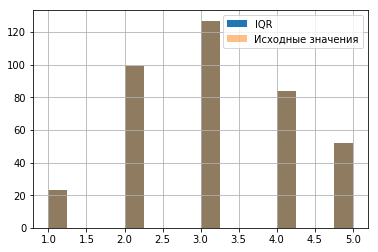

In [48]:
plot_column_info(students, column)

С данным признаком все хорошо. Оставляем как есть.

### Health
health — текущее состояние здоровья (от 1 - очень плохо до 5 - очень хорошо)

Признак может принимать только 5 выше указанных значения. Посмотрим, так ли это и не требуется ли дополнительная обработка.

In [49]:
column = 'health'
column_info(students, column)

Проведем анализ для переменной health
Всего значений: 393
Пустых значений: 15
Значений, упомянутых более 10 раз: 5
Уникальных значений: 5


,health
5.0,137
3.0,89
4.0,62
1.0,47
2.0,43


<class 'pandas.core.frame.DataFrame'>
Int64Index: 393 entries, 0 to 394
Data columns (total 1 columns):
health    378 non-null float64
dtypes: float64(1)
memory usage: 6.1 KB


Значений, требующих дополнительной обработки, нет. Есть 15 пустых значений.

Посмотрим на гистограмму этого признака:

25-й перцентиль: 3.0,
75-й перцентиль: 5.0,
IQR: 2.0, 
Границы значений: [1.0, 5.0.
Границы выбросов: [0.0, 8.0],
Выбросов Нет.


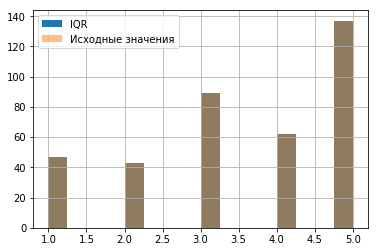

In [50]:
plot_column_info(students, column)

С данным признаком все хорошо. Оставляем как есть.

### Absences
absences — количество пропущенных занятий

25-й перцентиль: 0.0,
75-й перцентиль: 8.0,
IQR: 8.0, 
Границы значений: [0.0, 385.0.
Границы выбросов: [-12.0, 20.0],
Есть выбросы.


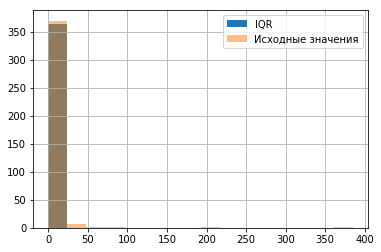

In [51]:
column = 'absences'
plot_column_info(students, column)

У данного признака присутствуют выбросы определенные с помощью IQR. Уберем их:

In [52]:
# Вынесем данное действие в предобработку
students = remove_outliers_iqr(students, column)

Постороим гистограмму признака после корректировки:

25-й перцентиль: 0.0,
75-й перцентиль: 7.0,
IQR: 7.0, 
Границы значений: [0.0, 20.0.
Границы выбросов: [-10.5, 17.5],
Есть выбросы.


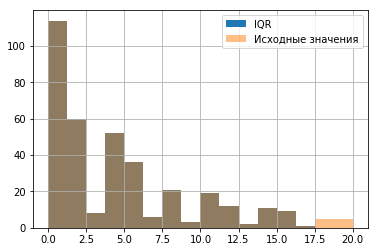

In [53]:
plot_column_info(students, column)

Выбросы для заново рассчитанного IQR все еще присутствуют. Оставим как есть.

### Score
score — баллы по госэкзамену по математике

25-й перцентиль: 40.0,
75-й перцентиль: 70.0,
IQR: 30.0, 
Границы значений: [0.0, 100.0.
Границы выбросов: [-5.0, 115.0],
Выбросов Нет.


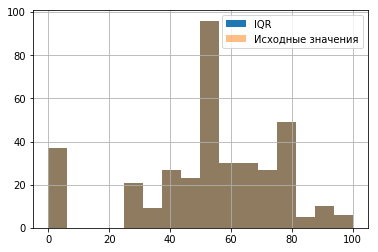

In [54]:
column = 'score'
plot_column_info(students, column)

С данным признаком все хорошо. Оставляем как есть.

---

## Корреляционный анализ количественных переменных

Выясним, какие столбцы коррелируют с количеством баллов на госэкзамене. Это поможет понять, какие параметры стоит оставить для модели, а какие — исключить. 

Корреляции рассмотрим только для числовых столбцов.

Для быстрого построения графиков зависимости переменных можно воспользоваться функцией pairplot из модуля seaborn:

In [55]:
correlation = students.corr()
correlation

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,health,absences,score
age,1.000000,-0.182949,-0.179096,0.093321,-0.008634,0.217645,0.062476,0.047375,0.146565,-0.061557,0.154950,-0.163148
Medu,-0.182949,1.000000,0.629099,-0.183697,0.097849,-0.255588,-0.018171,0.039720,0.051264,-0.038857,0.069416,0.220594
Fedu,-0.179096,0.629099,1.000000,-0.158145,0.015616,-0.289433,-0.030520,-0.012494,0.041891,0.026787,-0.019066,0.127207
traveltime,0.093321,-0.183697,-0.158145,1.000000,-0.100115,0.080707,-0.034237,-0.005917,0.035006,-0.021322,-0.044206,-0.072170
studytime,-0.008634,0.097849,0.015616,-0.100115,1.000000,-0.177974,0.022310,-0.134612,-0.039986,-0.084221,-0.071910,0.118298
failures,0.217645,-0.255588,-0.289433,0.080707,-0.177974,1.000000,0.011241,0.095059,0.112493,0.086826,0.070239,-0.347363
famrel,0.062476,-0.018171,-0.030520,-0.034237,0.022310,0.011241,1.000000,0.166615,0.068931,0.089272,-0.073266,0.062222
freetime,0.047375,0.039720,-0.012494,-0.005917,-0.134612,0.095059,0.166615,1.000000,0.276730,0.057498,0.100984,0.040745
goout,0.146565,0.051264,0.041891,0.035006,-0.039986,0.112493,0.068931,0.276730,1.000000,-0.001817,0.117416,-0.112900
health,-0.061557,-0.038857,0.026787,-0.021322,-0.084221,0.086826,0.089272,0.057498,-0.001817,1.000000,-0.019984,-0.071037


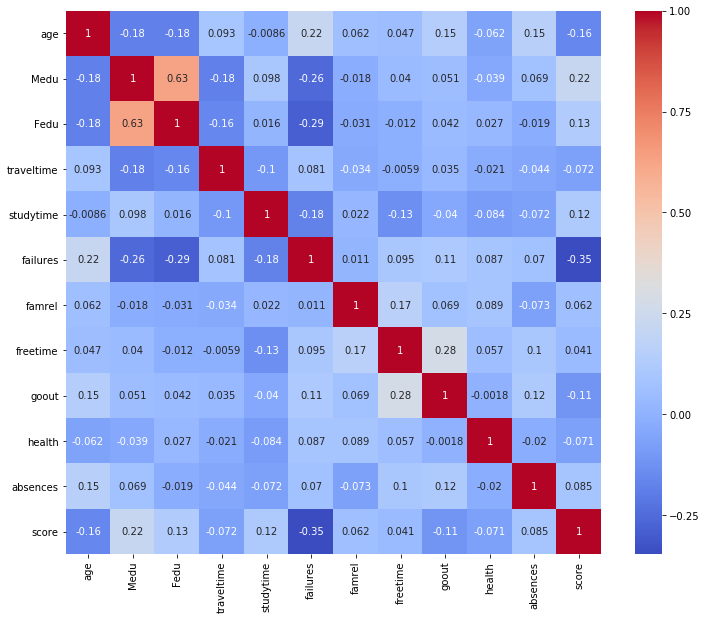

In [56]:
plt.figure(figsize=(12, 10))
sns.heatmap(correlation, annot=True, cmap='coolwarm')

In [57]:
def get_boxplot(data, column):
    fig, ax = plt.subplots(figsize = (14, 4))
    sns.boxplot(x=column, y='score', 
                data=data.loc[data.loc[:, column].isin(data.loc[:, column].value_counts().index[:10])],
               ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()

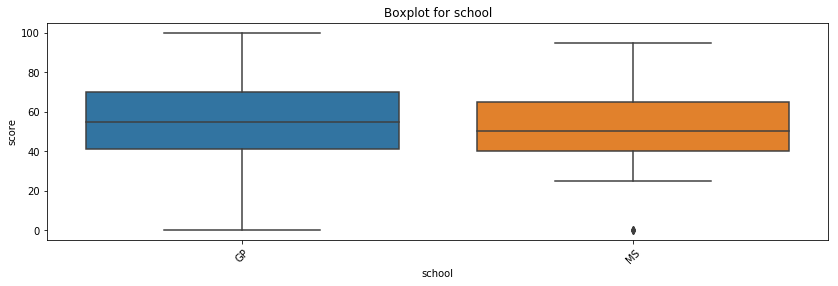

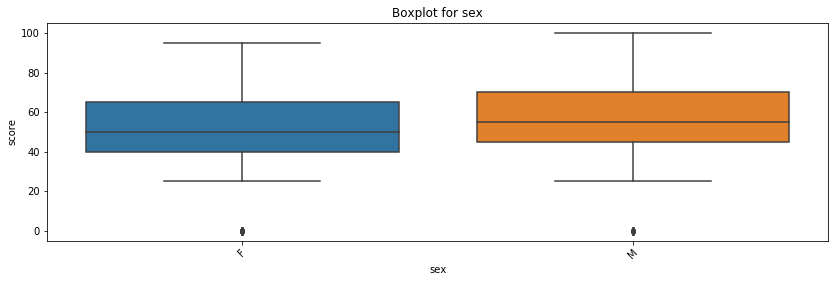

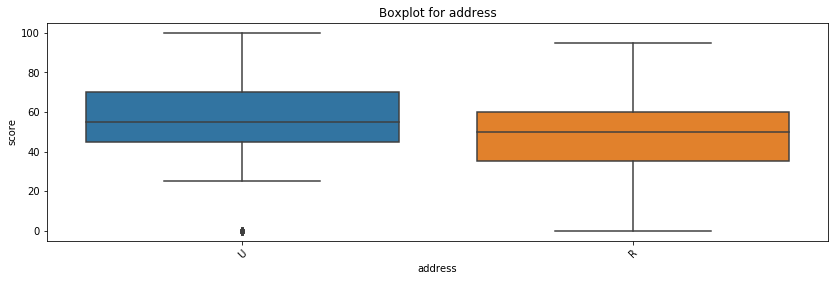

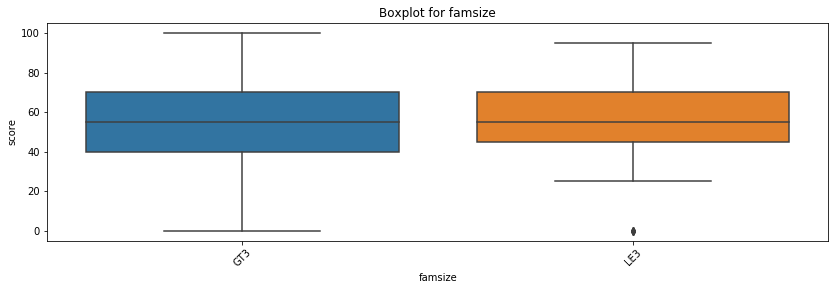

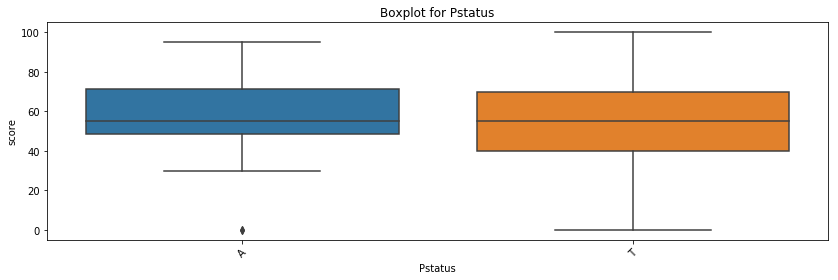

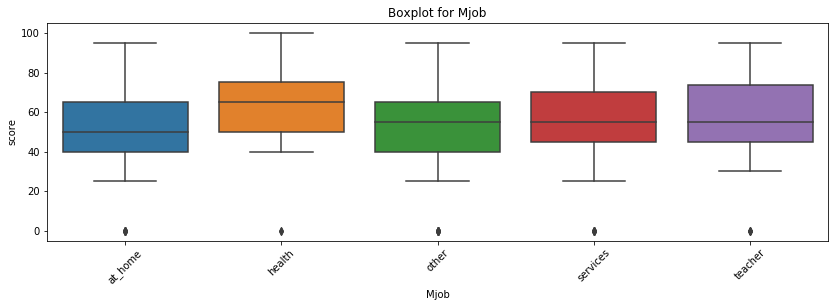

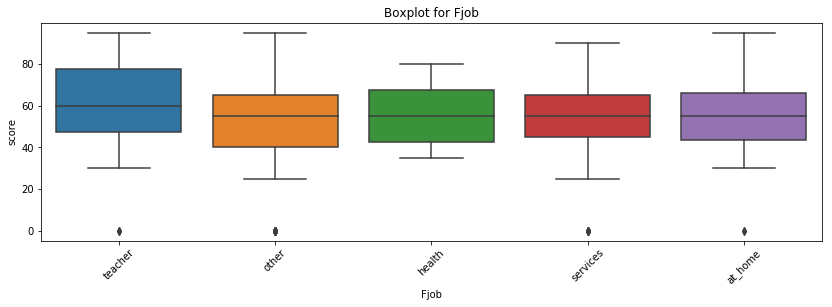

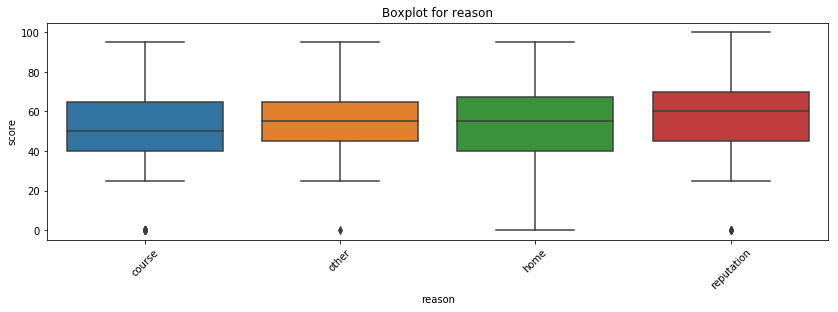

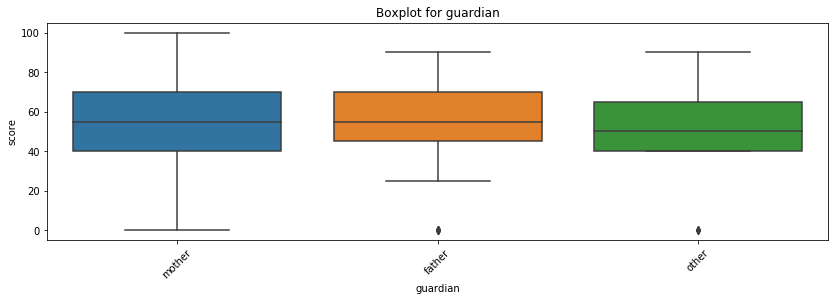

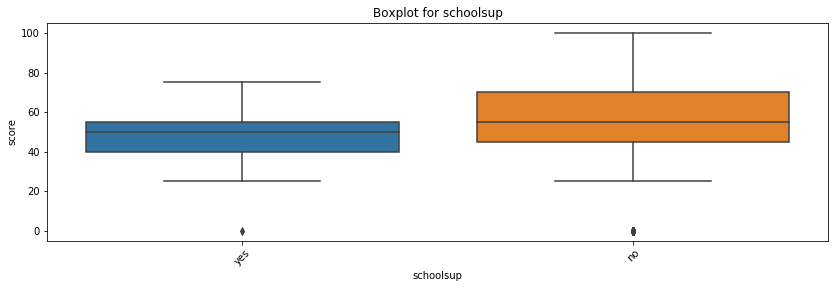

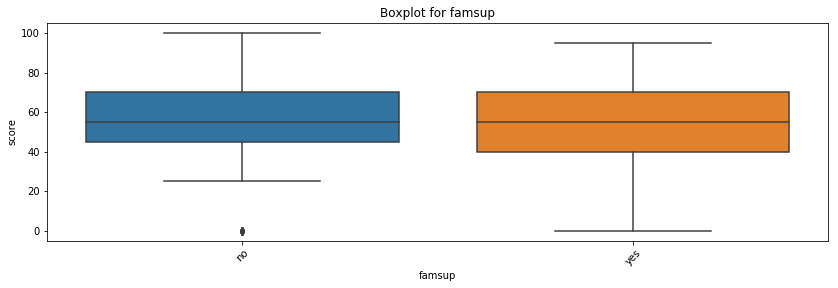

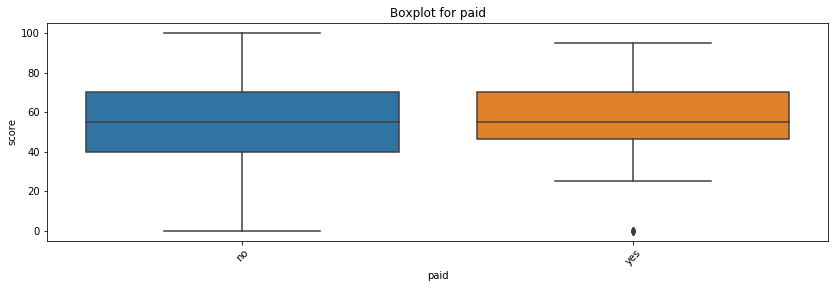

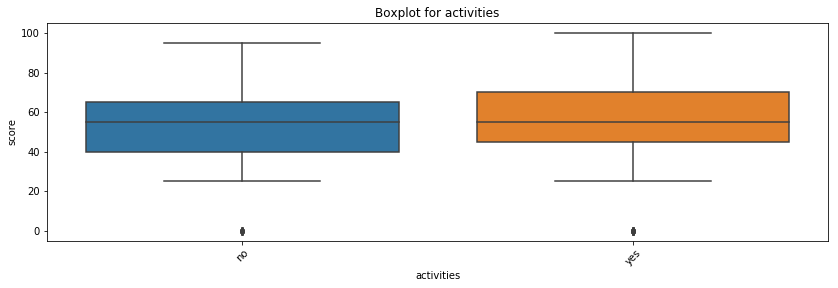

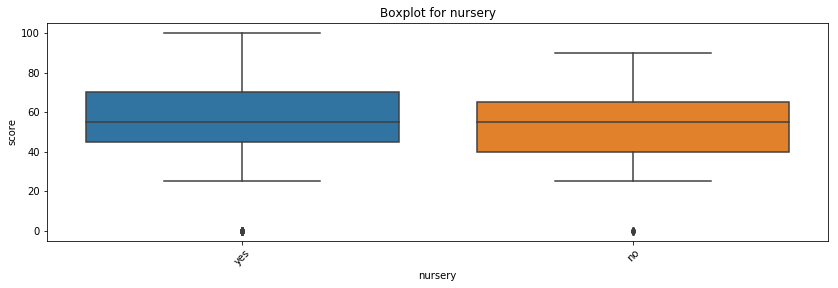

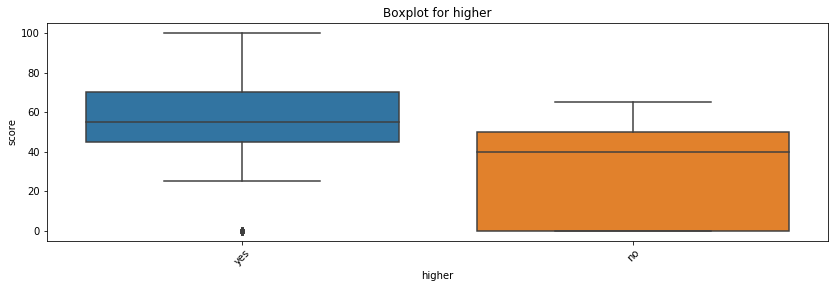

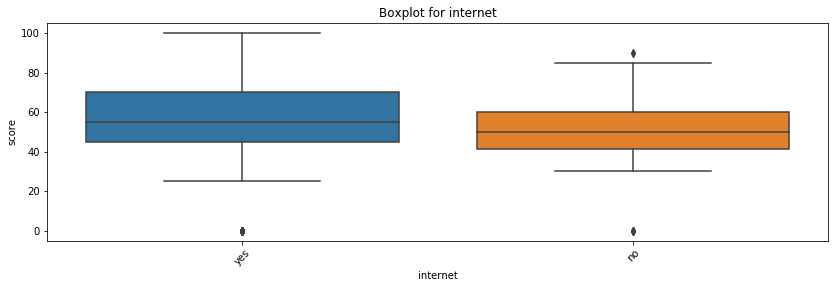

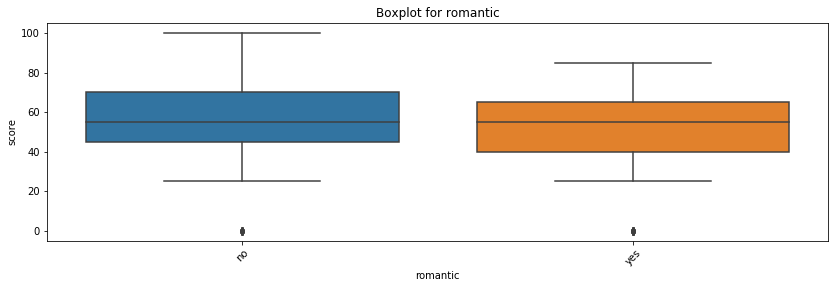

In [58]:
for col in columns_object:
    get_boxplot(students, col)

In [59]:
def get_stat_dif(data, column):
    cols = data.loc[:, column].value_counts().index[:10]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(data.loc[data.loc[:, column] == comb[0], 'score'], 
                     data.loc[data.loc[:, column] == comb[1], 'score']).pvalue \
            <= 0.05/len(combinations_all): # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break

In [60]:
for col in columns_object:
    get_stat_dif(students, col)

Найдены статистически значимые различия для колонки Mjob


In [61]:
students.query('famsize != famsize')

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
9,GP,M,15,U,NaN,NaN,3.0,4.0,other,other,home,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,yes,yes,no,5.0,5.0,1.0,5.0,0.0,75.0
32,GP,M,15,R,NaN,T,4.0,3.0,teacher,at_home,course,mother,1.0,2.0,0.0,no,yes,no,yes,NaN,yes,yes,yes,4.0,NaN,2.0,5.0,0.0,80.0
36,GP,M,15,U,NaN,T,4.0,3.0,teacher,services,home,mother,1.0,3.0,0.0,no,yes,no,yes,yes,yes,yes,no,5.0,4.0,3.0,4.0,2.0,90.0
76,GP,M,15,U,NaN,T,4.0,0.0,teacher,other,course,mother,2.0,4.0,0.0,no,no,no,yes,yes,NaN,yes,no,3.0,4.0,3.0,1.0,8.0,50.0
78,GP,M,17,U,NaN,T,2.0,1.0,other,other,home,mother,2.0,1.0,3.0,yes,NaN,no,yes,yes,no,yes,no,4.0,5.0,1.0,3.0,2.0,50.0
79,GP,F,16,U,NaN,T,3.0,4.0,at_home,other,course,mother,1.0,2.0,0.0,NaN,yes,no,no,yes,yes,yes,no,2.0,4.0,3.0,3.0,12.0,25.0
114,GP,M,15,R,NaN,T,2.0,1.0,health,services,reputation,mother,1.0,2.0,NaN,no,no,no,yes,yes,yes,yes,yes,5.0,4.0,2.0,5.0,8.0,45.0
128,GP,M,18,R,NaN,T,2.0,2.0,NaN,other,reputation,mother,1.0,1.0,2.0,no,yes,no,yes,yes,yes,yes,no,3.0,3.0,3.0,4.0,0.0,0.0
129,GP,M,16,R,NaN,T,4.0,4.0,teacher,teacher,course,mother,1.0,NaN,0.0,no,no,yes,yes,yes,yes,yes,no,3.0,5.0,5.0,4.0,NaN,90.0


In [62]:
students.query('address != address')

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,health,absences,score
6,GP,M,16,NaN,LE3,T,2.0,2.0,other,other,home,mother,1.0,2.0,0.0,no,no,no,no,yes,yes,yes,no,4.0,4.0,4.0,3.0,0.0,55.0
52,GP,M,15,NaN,LE3,A,4.0,2.0,health,NaN,other,father,2.0,1.0,1.0,no,NaN,no,no,yes,yes,NaN,no,5.0,5.0,5.0,5.0,6.0,50.0
75,GP,M,15,NaN,GT3,T,4.0,3.0,teacher,other,home,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,yes,yes,NaN,NaN,3.0,3.0,5.0,6.0,50.0
92,GP,F,16,NaN,LE3,T,NaN,1.0,other,other,home,father,1.0,2.0,0.0,yes,yes,no,no,yes,yes,no,no,3.0,3.0,NaN,2.0,4.0,30.0
96,GP,M,16,NaN,GT3,NaN,4.0,3.0,services,other,reputation,mother,2.0,1.0,0.0,yes,yes,NaN,yes,no,NaN,yes,no,3.0,3.0,3.0,4.0,2.0,75.0
159,GP,M,16,NaN,GT3,T,3.0,NaN,other,services,course,father,1.0,2.0,1.0,no,yes,yes,no,yes,yes,yes,yes,4.0,5.0,5.0,5.0,4.0,60.0
168,GP,F,16,NaN,GT3,T,2.0,2.0,other,other,home,mother,1.0,2.0,0.0,no,yes,yes,no,no,yes,yes,no,5.0,1.0,5.0,4.0,0.0,0.0
241,GP,M,17,NaN,LE3,A,4.0,4.0,teacher,other,course,mother,NaN,2.0,0.0,no,yes,yes,no,yes,yes,yes,no,3.0,3.0,NaN,4.0,2.0,60.0
254,GP,M,17,NaN,NaN,T,2.0,1.0,other,other,course,mother,1.0,1.0,0.0,no,no,no,no,no,yes,yes,no,4.0,4.0,2.0,5.0,NaN,60.0
270,GP,F,19,NaN,GT3,T,3.0,3.0,other,services,home,other,1.0,2.0,2.0,no,yes,yes,yes,yes,yes,yes,no,4.0,3.0,5.0,5.0,NaN,NaN


In [63]:
students.query('traveltime == 1.0').groupby(['traveltime'])['address'].value_counts()

traveltime  address
1.0         U          191
            R           33
Name: address, dtype: int64

In [64]:
students.query('studytime != studytime')

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,health,absences,score
17,GP,F,16,U,GT3,T,3.0,3.0,other,NaN,reputation,mother,3.0,NaN,0.0,yes,NaN,no,yes,yes,yes,no,no,5.0,3.0,2.0,4.0,4.0,50.0
91,GP,F,15,U,GT3,T,4.0,3.0,services,other,reputation,mother,1.0,NaN,NaN,no,no,yes,yes,yes,yes,yes,no,4.0,5.0,5.0,1.0,4.0,90.0
112,GP,F,16,U,GT3,NaN,2.0,2.0,at_home,other,NaN,mother,NaN,NaN,1.0,yes,no,no,yes,yes,yes,yes,NaN,3.0,1.0,2.0,5.0,6.0,65.0
129,GP,M,16,R,NaN,T,4.0,4.0,teacher,teacher,course,mother,1.0,NaN,0.0,no,no,yes,yes,yes,yes,yes,no,3.0,5.0,5.0,4.0,NaN,90.0
227,GP,M,17,U,LE3,NaN,2.0,3.0,services,services,reputation,father,1.0,NaN,0.0,no,yes,yes,no,no,NaN,yes,no,5.0,3.0,3.0,3.0,NaN,60.0
266,GP,M,17,U,GT3,NaN,3.0,1.0,services,NaN,other,mother,1.0,NaN,0.0,no,no,yes,yes,yes,yes,yes,NaN,5.0,4.0,4.0,NaN,2.0,50.0
314,GP,F,19,U,GT3,T,1.0,1.0,at_home,health,home,other,1.0,NaN,2.0,no,no,no,no,no,yes,yes,yes,4.0,NaN,2.0,3.0,14.0,65.0
